# DMD on many slow signals

The purpose of this notebook is to test if DMD is able to capture all underlying modes when the analyzed signal is a superposition of many slow frequencies.

In [1]:
from pydmd import BOPDMD
from pydmd.preprocessing import hankel_preprocessing
from pydmd.plotter import plot_summary
from signal_generator import SignalGenerator
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
# choose whether to do DMD on the data with mean removed and scaled to unit variance
# set to True to remove mean and scale to unit variance
scaler = StandardScaler(with_mean=False, with_std=False)

Change the default value of the frequencies so that they are all in the 0-1 rad/s range. The resulting signal is the superposition of six sinusoids with low frequencies, plus some noise.

In [3]:
signal_generator = SignalGenerator(
    t_length=80,
    omega_f1slow=0.2,
    omega_f2slow=0.3,
    omega_f1med=0.5, 
    omega_f2med=0.6, 
    omega_f1fast=0.8,
    omega_f2fast=0.9,
    )
signal_generator.add_signal("all")
signal_generator.add_noise(noise_std=0.1, random_seed=42)

Plot the six sinusoids plus the resulting signal

In [4]:
plt.rcParams.update({'font.size': 28})

fig = plt.figure(figsize=(50, 50))

vmin = -1.8; vmax = 1.8
levels = np.arange(vmin, vmax+0.1, 0.1)

ax = fig.add_subplot(4, 2, 1)
contour = ax.contourf(signal_generator.T, signal_generator.X, signal_generator.f1_slow, levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Signal 1, omega = {signal_generator.omega_f1slow} rad/s')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(4, 2, 2)
contour = ax.contourf(signal_generator.T, signal_generator.X, signal_generator.f2_slow, levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Signal 2, omega = {signal_generator.omega_f2slow} rad/s')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(4, 2, 3)
contour = ax.contourf(signal_generator.T, signal_generator.X, signal_generator.f1_med, levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Signal 3, omega = {signal_generator.omega_f1med} rad/s')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(4, 2, 4)
contour = ax.contourf(signal_generator.T, signal_generator.X, signal_generator.f2_med, levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Signal 4, omega = {signal_generator.omega_f2med} rad/s')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(4, 2, 5)
contour = ax.contourf(signal_generator.T, signal_generator.X, signal_generator.f1_fast, levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Signal 5, omega = {signal_generator.omega_f1fast} rad/s')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(4, 2, 6)
contour = ax.contourf(signal_generator.T, signal_generator.X, signal_generator.f2_fast, levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Signal 6, omega = {signal_generator.omega_f2fast} rad/s')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(4, 2, 7)
contour = ax.contourf(signal_generator.T, signal_generator.X, signal_generator.f, levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('All + Noise')
plt.colorbar(contour, ax=ax, orientation="vertical")

plt.show()

Perform optimized DMD using the BOPDMD class

In [5]:
svd_rank = 12  # the signal is composed of 6 distinct modes, so we need 2 DMD eigenvalues for each oscillation
delay = 2  # need time delay embedding to be able to recover the proper rank structure
optdmd = BOPDMD(svd_rank=svd_rank, num_trials=0)
delay_optdmd = hankel_preprocessing(optdmd, d=delay)

In [6]:
# fit DMD model to 80% of the data, save the rest for testing
train_frac = 0.8
f_train = signal_generator.f[:int(train_frac * signal_generator.f.shape[0]), :]
t_train = signal_generator.t[:int(train_frac * signal_generator.f.shape[0])]
f_test = signal_generator.f[int(train_frac * signal_generator.f.shape[0]):, :]
t_test = signal_generator.t[int(train_frac * signal_generator.f.shape[0]):]

In [7]:
t_delay = t_train[:-delay+1]
f_train_norm = scaler.fit_transform(f_train)
delay_optdmd.fit(f_train_norm.T, t=t_delay)

/Users/dsalvadorjasin/Documents/projects/MetOffice/DMD/toy_dataset/.venv/lib/python3.10/site-packages/pydmd/bopdmd.py:751: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)


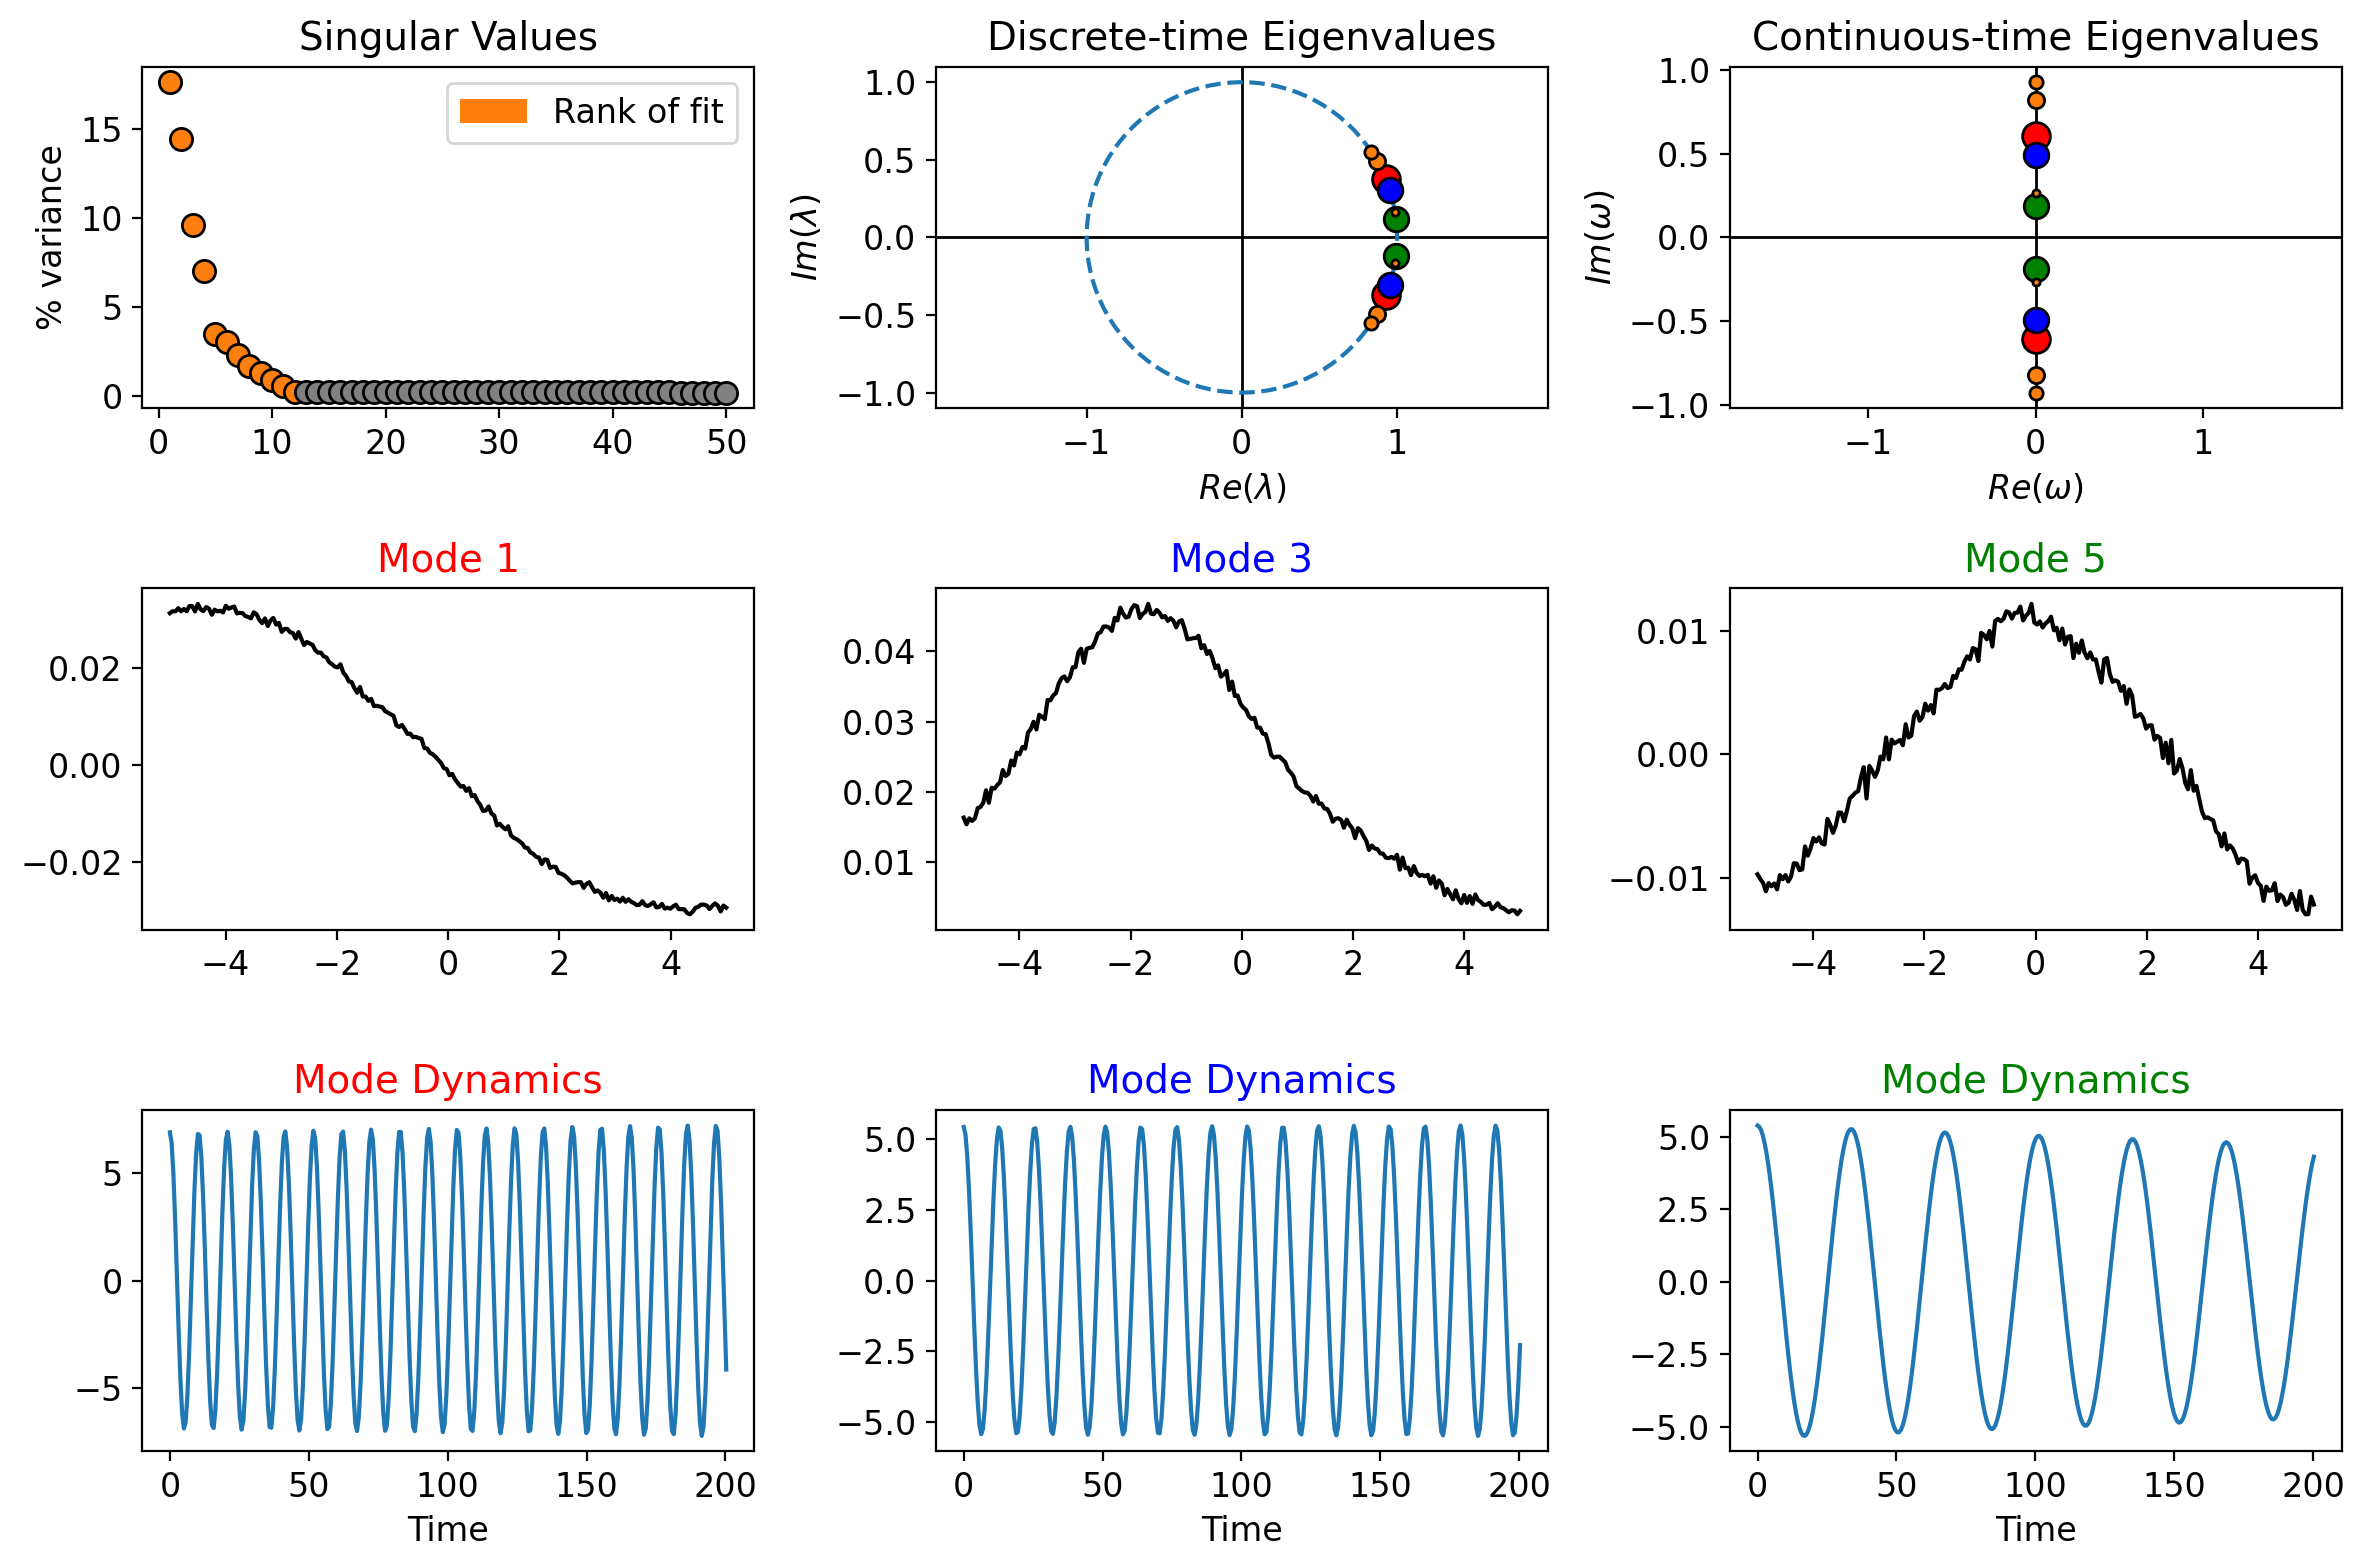

In [8]:
plt.rcParams.update({'font.size': 12})
plot_summary(delay_optdmd, x=signal_generator.x, d=delay, index_modes=[0, 2, 4])

In [9]:
# sort by decreasing amplitude
sorted_index = np.argsort(np.abs(delay_optdmd.amplitudes))[::-1]
delay_optdmd.eigs[sorted_index]

array([ 2.47590536e-04-0.60686849j,  2.47590536e-04+0.60686849j,
        5.49960122e-05-0.4919108j ,  5.49960122e-05+0.4919108j ,
       -6.68691007e-04+0.18612742j, -6.68691007e-04-0.18612742j,
        1.43176853e-04-0.81760281j,  1.43176853e-04+0.81760281j,
       -6.95501188e-04+0.92531024j, -6.95501188e-04-0.92531024j,
       -6.99384786e-04-0.26587036j, -6.99384786e-04+0.26587036j])

In [10]:
eigs = delay_optdmd.eigs[sorted_index]
modes = delay_optdmd.modes[:, sorted_index]
dynamics = delay_optdmd.dynamics[sorted_index, :]
amps = delay_optdmd.amplitudes[sorted_index]

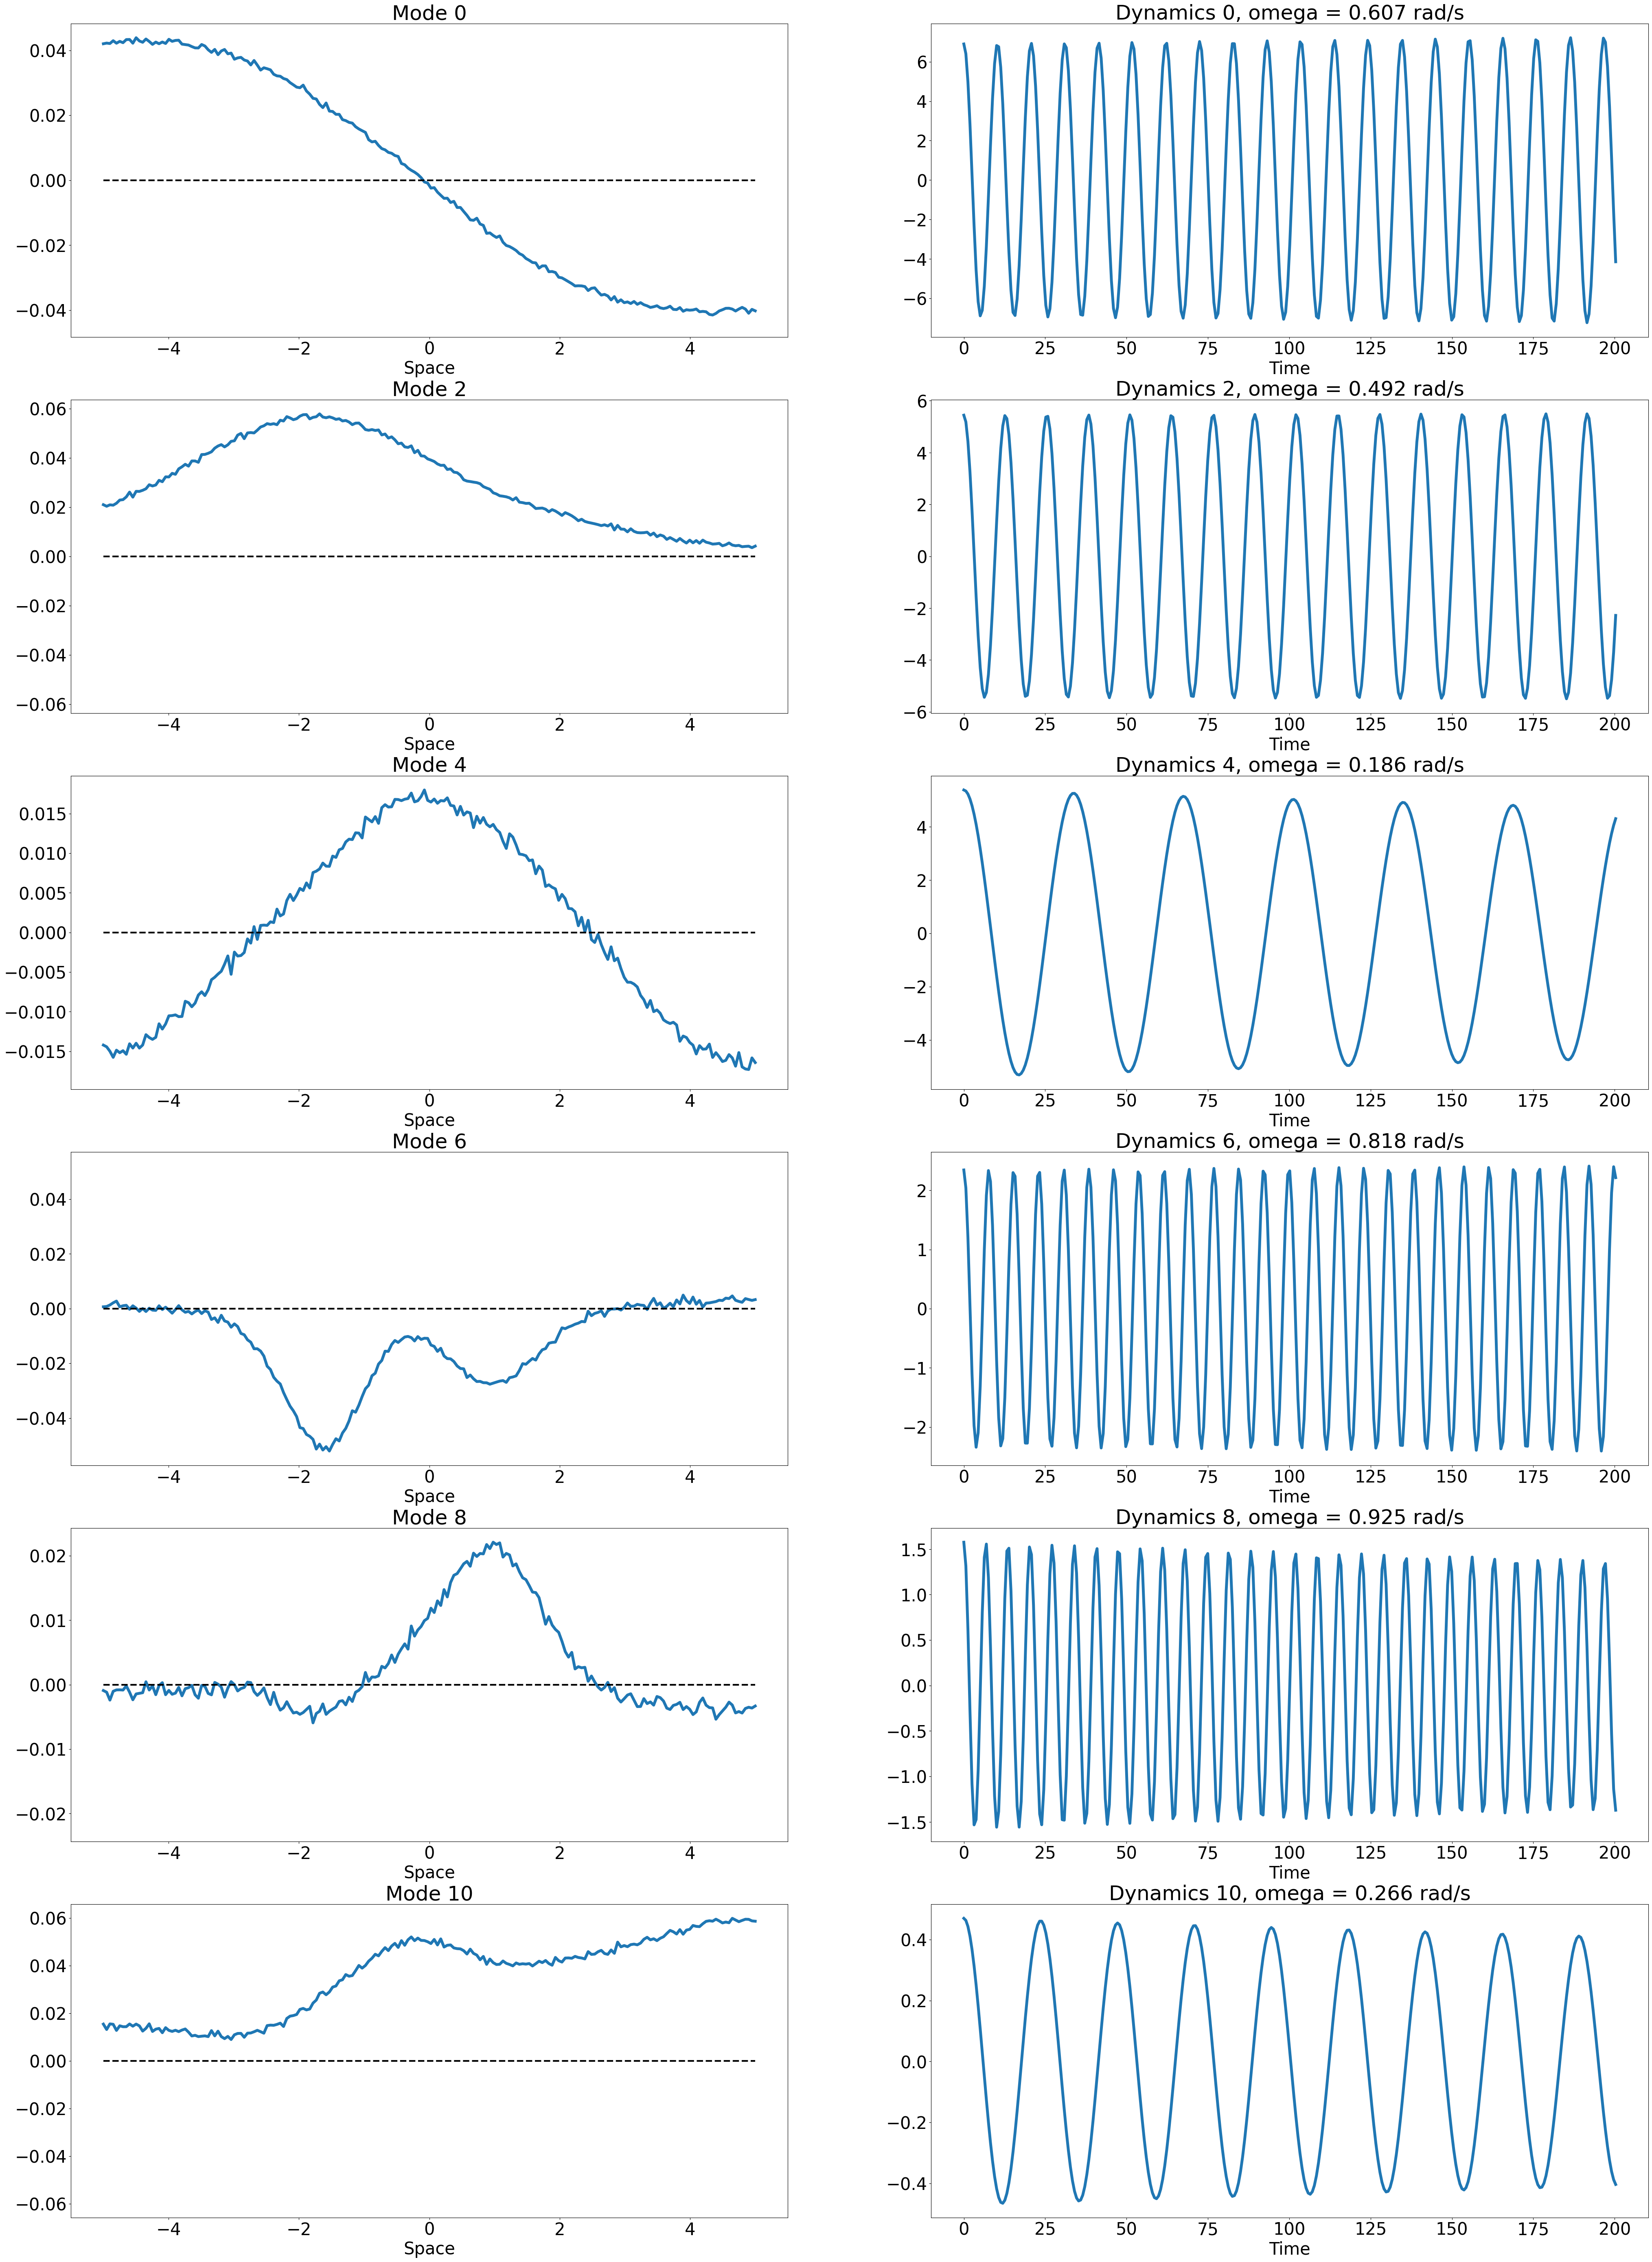

In [11]:
# plot the spatial modes and their dynamics

plt.rcParams.update({'font.size': 30})

which_modes = [0, 2, 4, 6, 8, 10]
fig, axs = plt.subplots(6, 2, figsize=(50, 70))
axs = axs.flatten()

for i, mode in enumerate(which_modes):
    axs[2*i].plot(signal_generator.x, modes[:signal_generator.x.shape[0], mode].real, linewidth=5)
    axs[2*i].set_title(f'Mode {mode}')
    axs[2*i].set_xlabel('Space')
    max_val = np.max(np.abs(modes[:signal_generator.x.shape[0], mode].real))
    axs[2*i].set_ylim([-max_val*1.1, max_val*1.1])
    axs[2*i].hlines(0, signal_generator.x[0], signal_generator.x[-1], color='k', linestyle='--', linewidth=3)

    axs[2*i+1].plot(t_delay, dynamics[mode, :].real, linewidth=5)
    axs[2*i+1].set_title(f'Dynamics {mode}, omega = {np.round(np.abs(eigs[mode].imag), 3)} rad/s')
    axs[2*i+1].set_xlabel('Time')

plt.show()


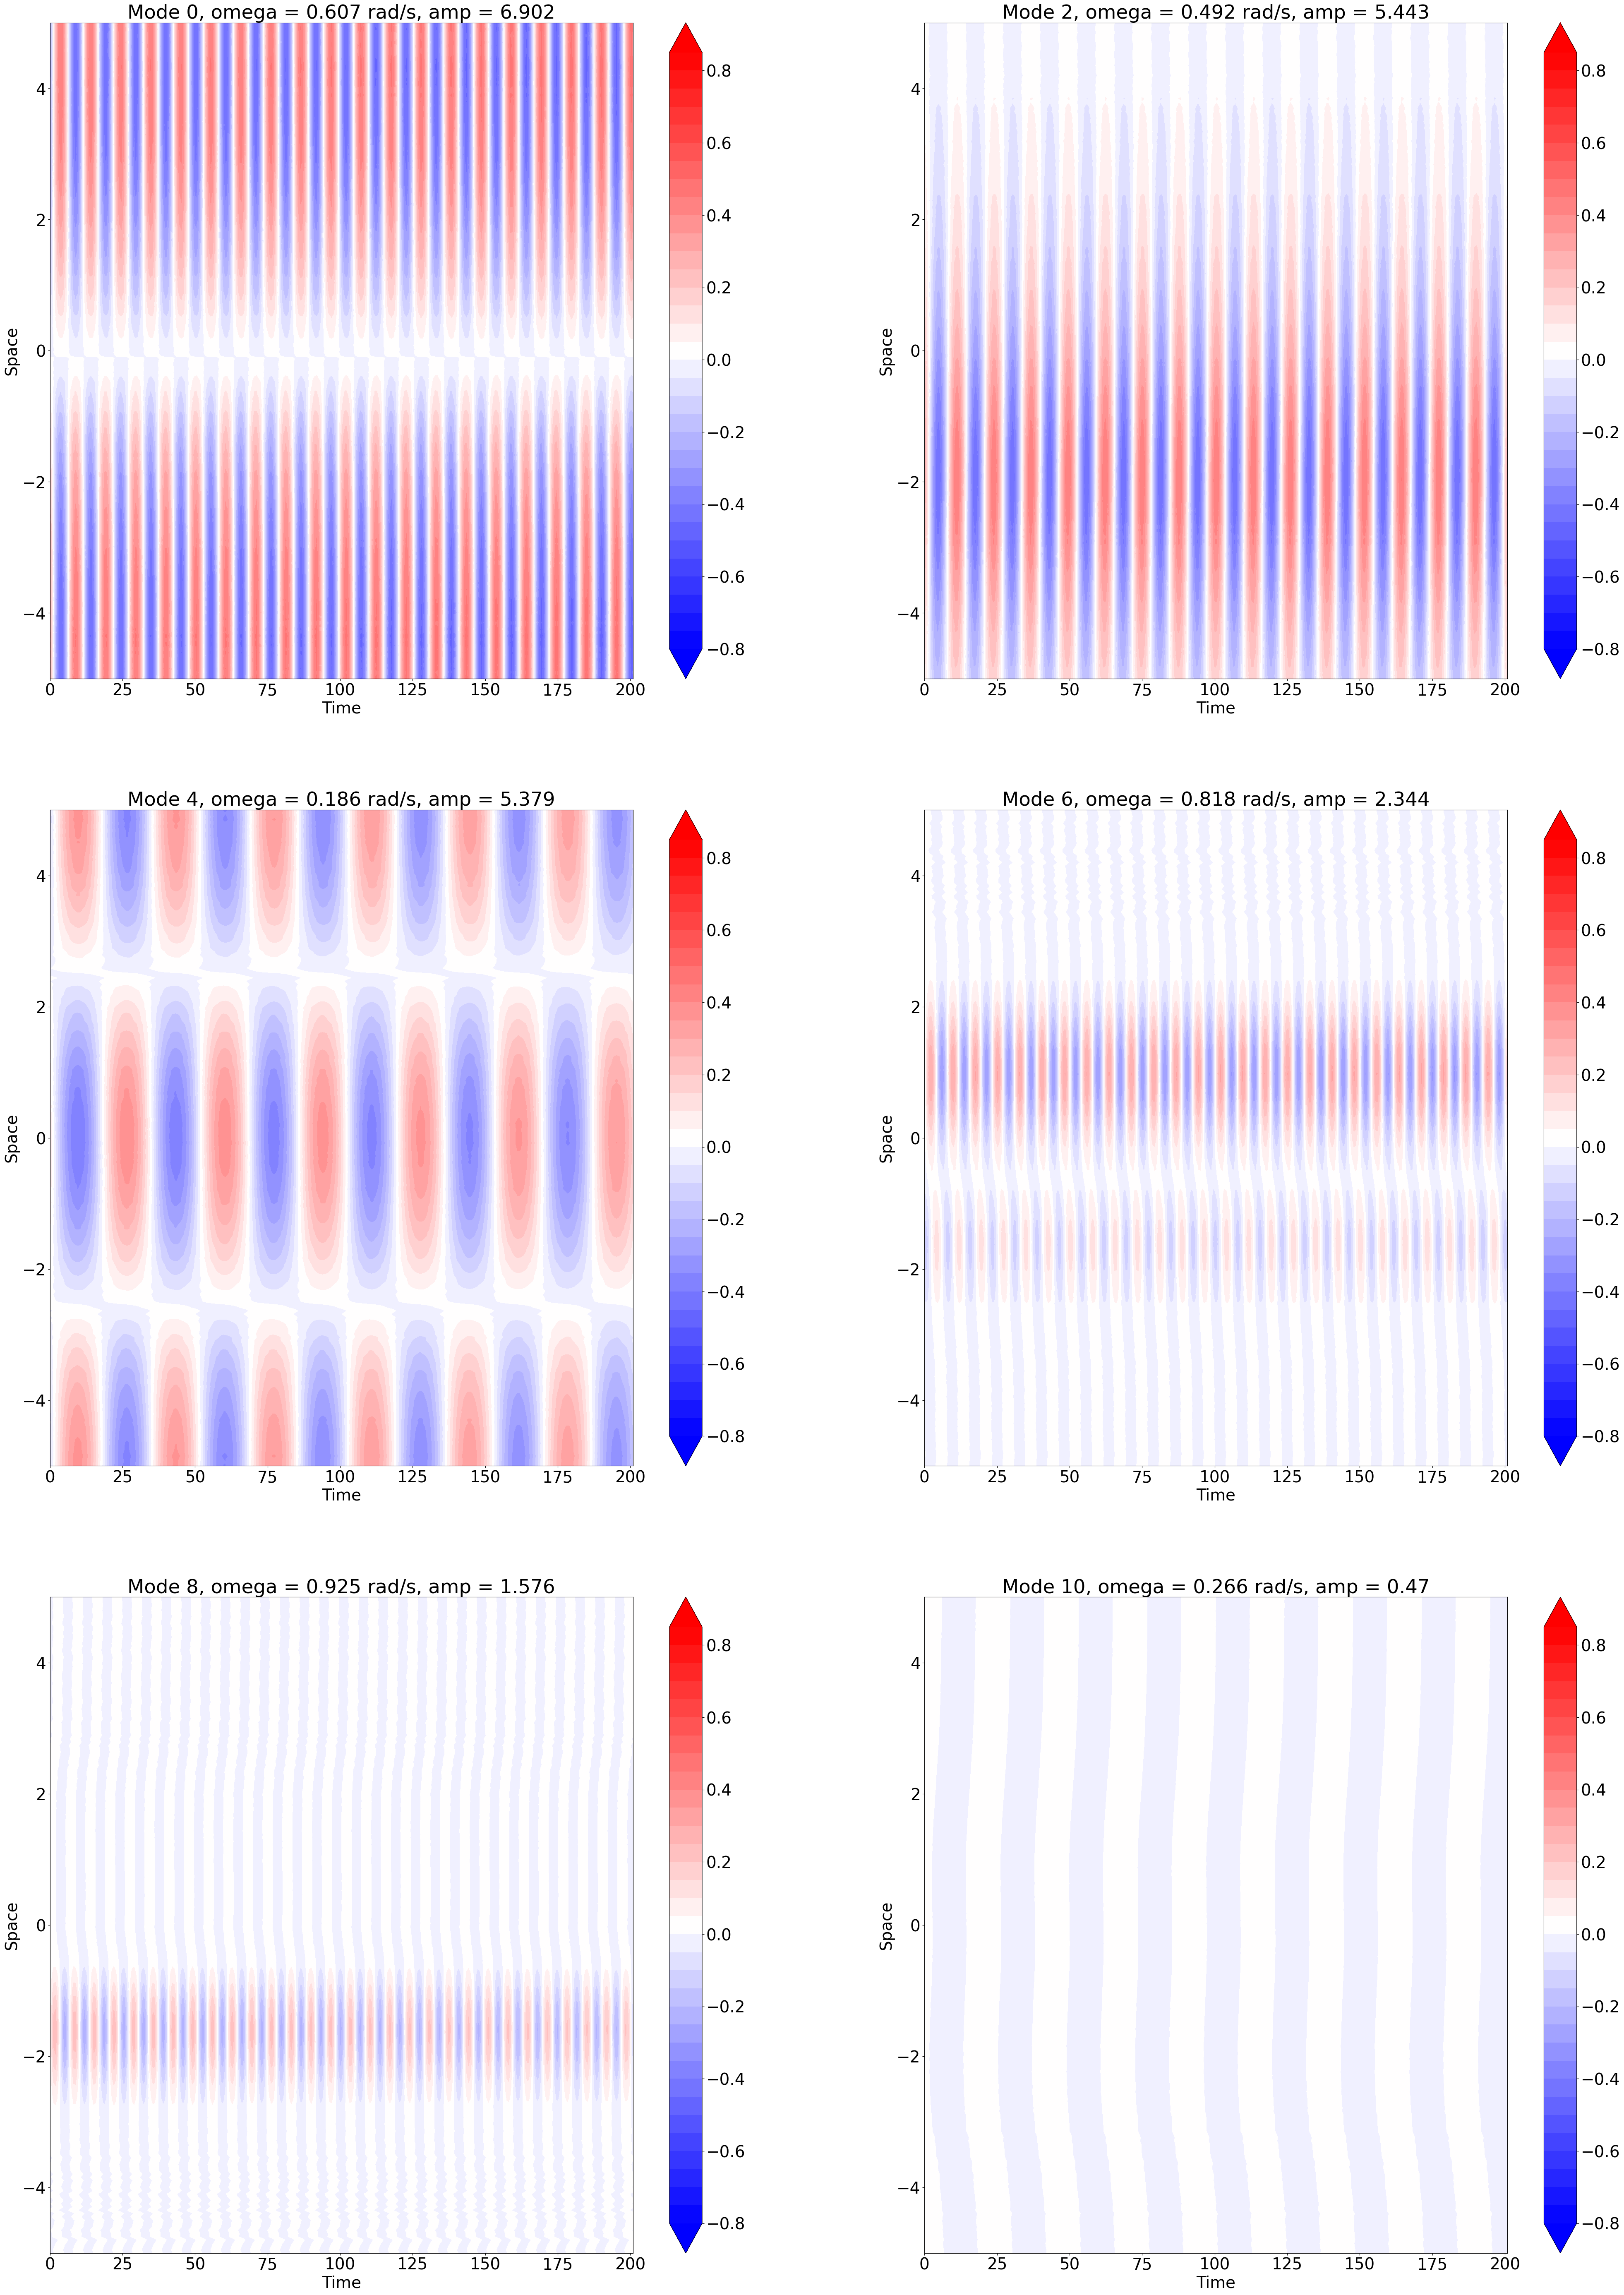

In [12]:
# plot contours of the reconstructed data from each mode
# these should ideally be the same as the individual signals that compose the data

plt.rcParams.update({'font.size': 28})

which_modes = [0, 2, 4, 6, 8, 10]
fig, axs = plt.subplots(3, 2, figsize=(50, 70))
axs = axs.flatten()

vmin = -0.8; vmax = 0.8
levels = np.arange(vmin, vmax+0.1, 0.05)

X, T = np.meshgrid(signal_generator.x, t_train)

for i, mode in enumerate(which_modes):
    reconstruction = np.linalg.multi_dot(
        [modes[:, mode].reshape(-1, 1), np.diag([amps[mode]]), np.exp(np.outer(eigs[mode], t_train))]
        ).real  # this is the reconstruction of the data from each DMD mode
    reconstruction = reconstruction[:signal_generator.x.shape[0], :].T
    reconstruction = scaler.inverse_transform(reconstruction)
    contour = axs[i].contourf(T, X, reconstruction, levels=levels, cmap='bwr', extend='both')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Space')
    axs[i].set_title(f'Mode {mode}, omega = {np.round(np.abs(eigs[mode].imag), 3)} rad/s, amp = {np.round(amps[mode], 3)}')
    plt.colorbar(contour, ax=axs[i], orientation="vertical")



Perform a forecast using the opt DMD model

In [13]:
forecast = delay_optdmd.forecast(t_test)
forecast = forecast[:signal_generator.x.shape[0], :]  # note than need to do this because of the time delay embedding
forecast = forecast.T
forecast = forecast.real
forecast = scaler.inverse_transform(forecast)

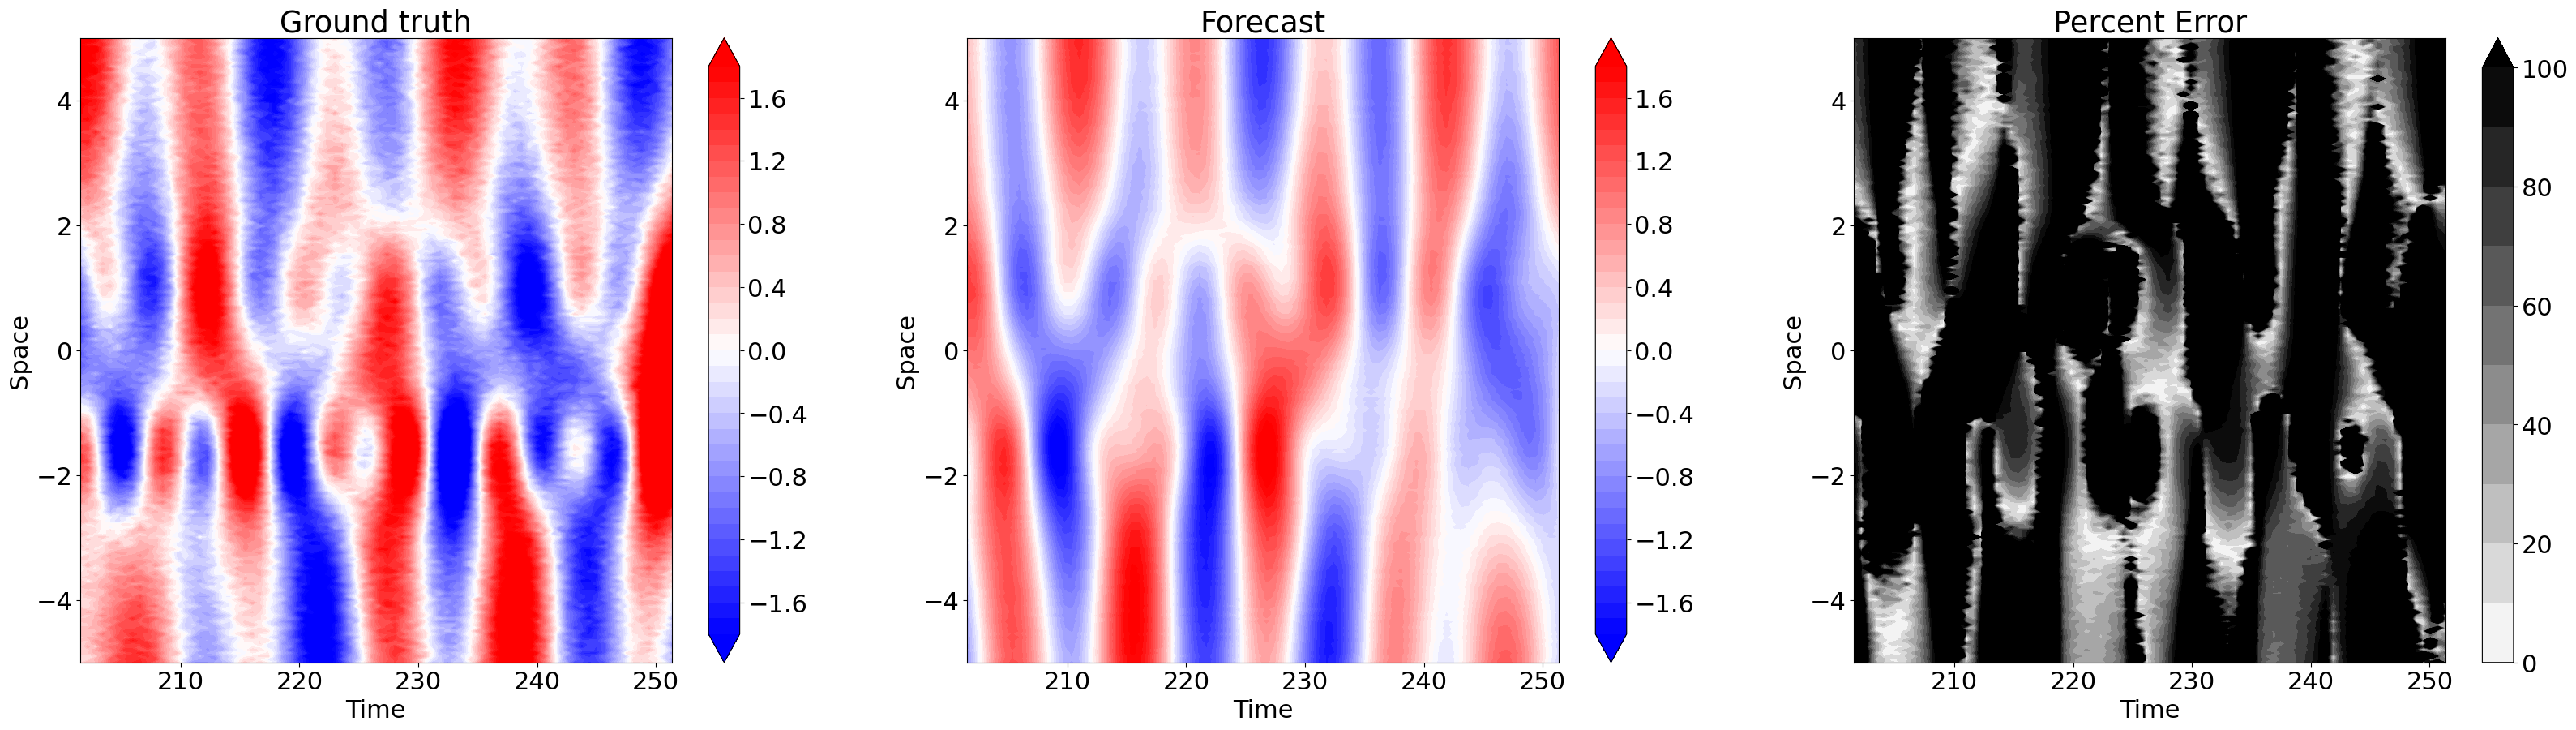

In [14]:
# compare the forecast to the ground truth

plt.rcParams.update({'font.size': 22})

X, T = np.meshgrid(signal_generator.x, t_test) 

fig = plt.figure(figsize=(40, 10))

vmin = -1.8; vmax = 1.8
levels = np.arange(vmin, vmax+0.1, 0.1)

ax = fig.add_subplot(1, 3, 1)
contour = ax.contourf(T, X, f_test, levels=levels, cmap='bwr', extend="both")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title("Ground truth")
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 3, 2)
contour = ax.contourf(T, X, forecast, levels=levels, cmap='bwr', extend="both")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Forecast')
plt.colorbar(contour, ax=ax, orientation="vertical")

# plot the percent error
percent_error = np.abs(f_test - forecast) / np.abs(f_test) * 100
ax = fig.add_subplot(1, 3, 3)
contour = ax.contourf(T, X, percent_error, levels=np.arange(0, 101, 10), cmap='gray_r', extend="max")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Percent Error')
plt.colorbar(contour, ax=ax, orientation="vertical")

plt.show()

Perform optimized DMD with constraints.
Constrain to imaginary + conjugate, i.e. constrain eigenvalues to be purely imaginary and to always appear with their complex conjugate. This can be especially helpful for dealing with noise and preventing growth/decay of the modes.

In [15]:
optdmd = BOPDMD(svd_rank=svd_rank, num_trials=0, eig_constraints={"imag", "conjugate_pairs"})
delay_optdmd = hankel_preprocessing(optdmd, d=delay)
delay_optdmd.fit(f_train_norm.T, t=t_delay)

/Users/dsalvadorjasin/Documents/projects/MetOffice/DMD/toy_dataset/.venv/lib/python3.10/site-packages/pydmd/bopdmd.py:751: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)


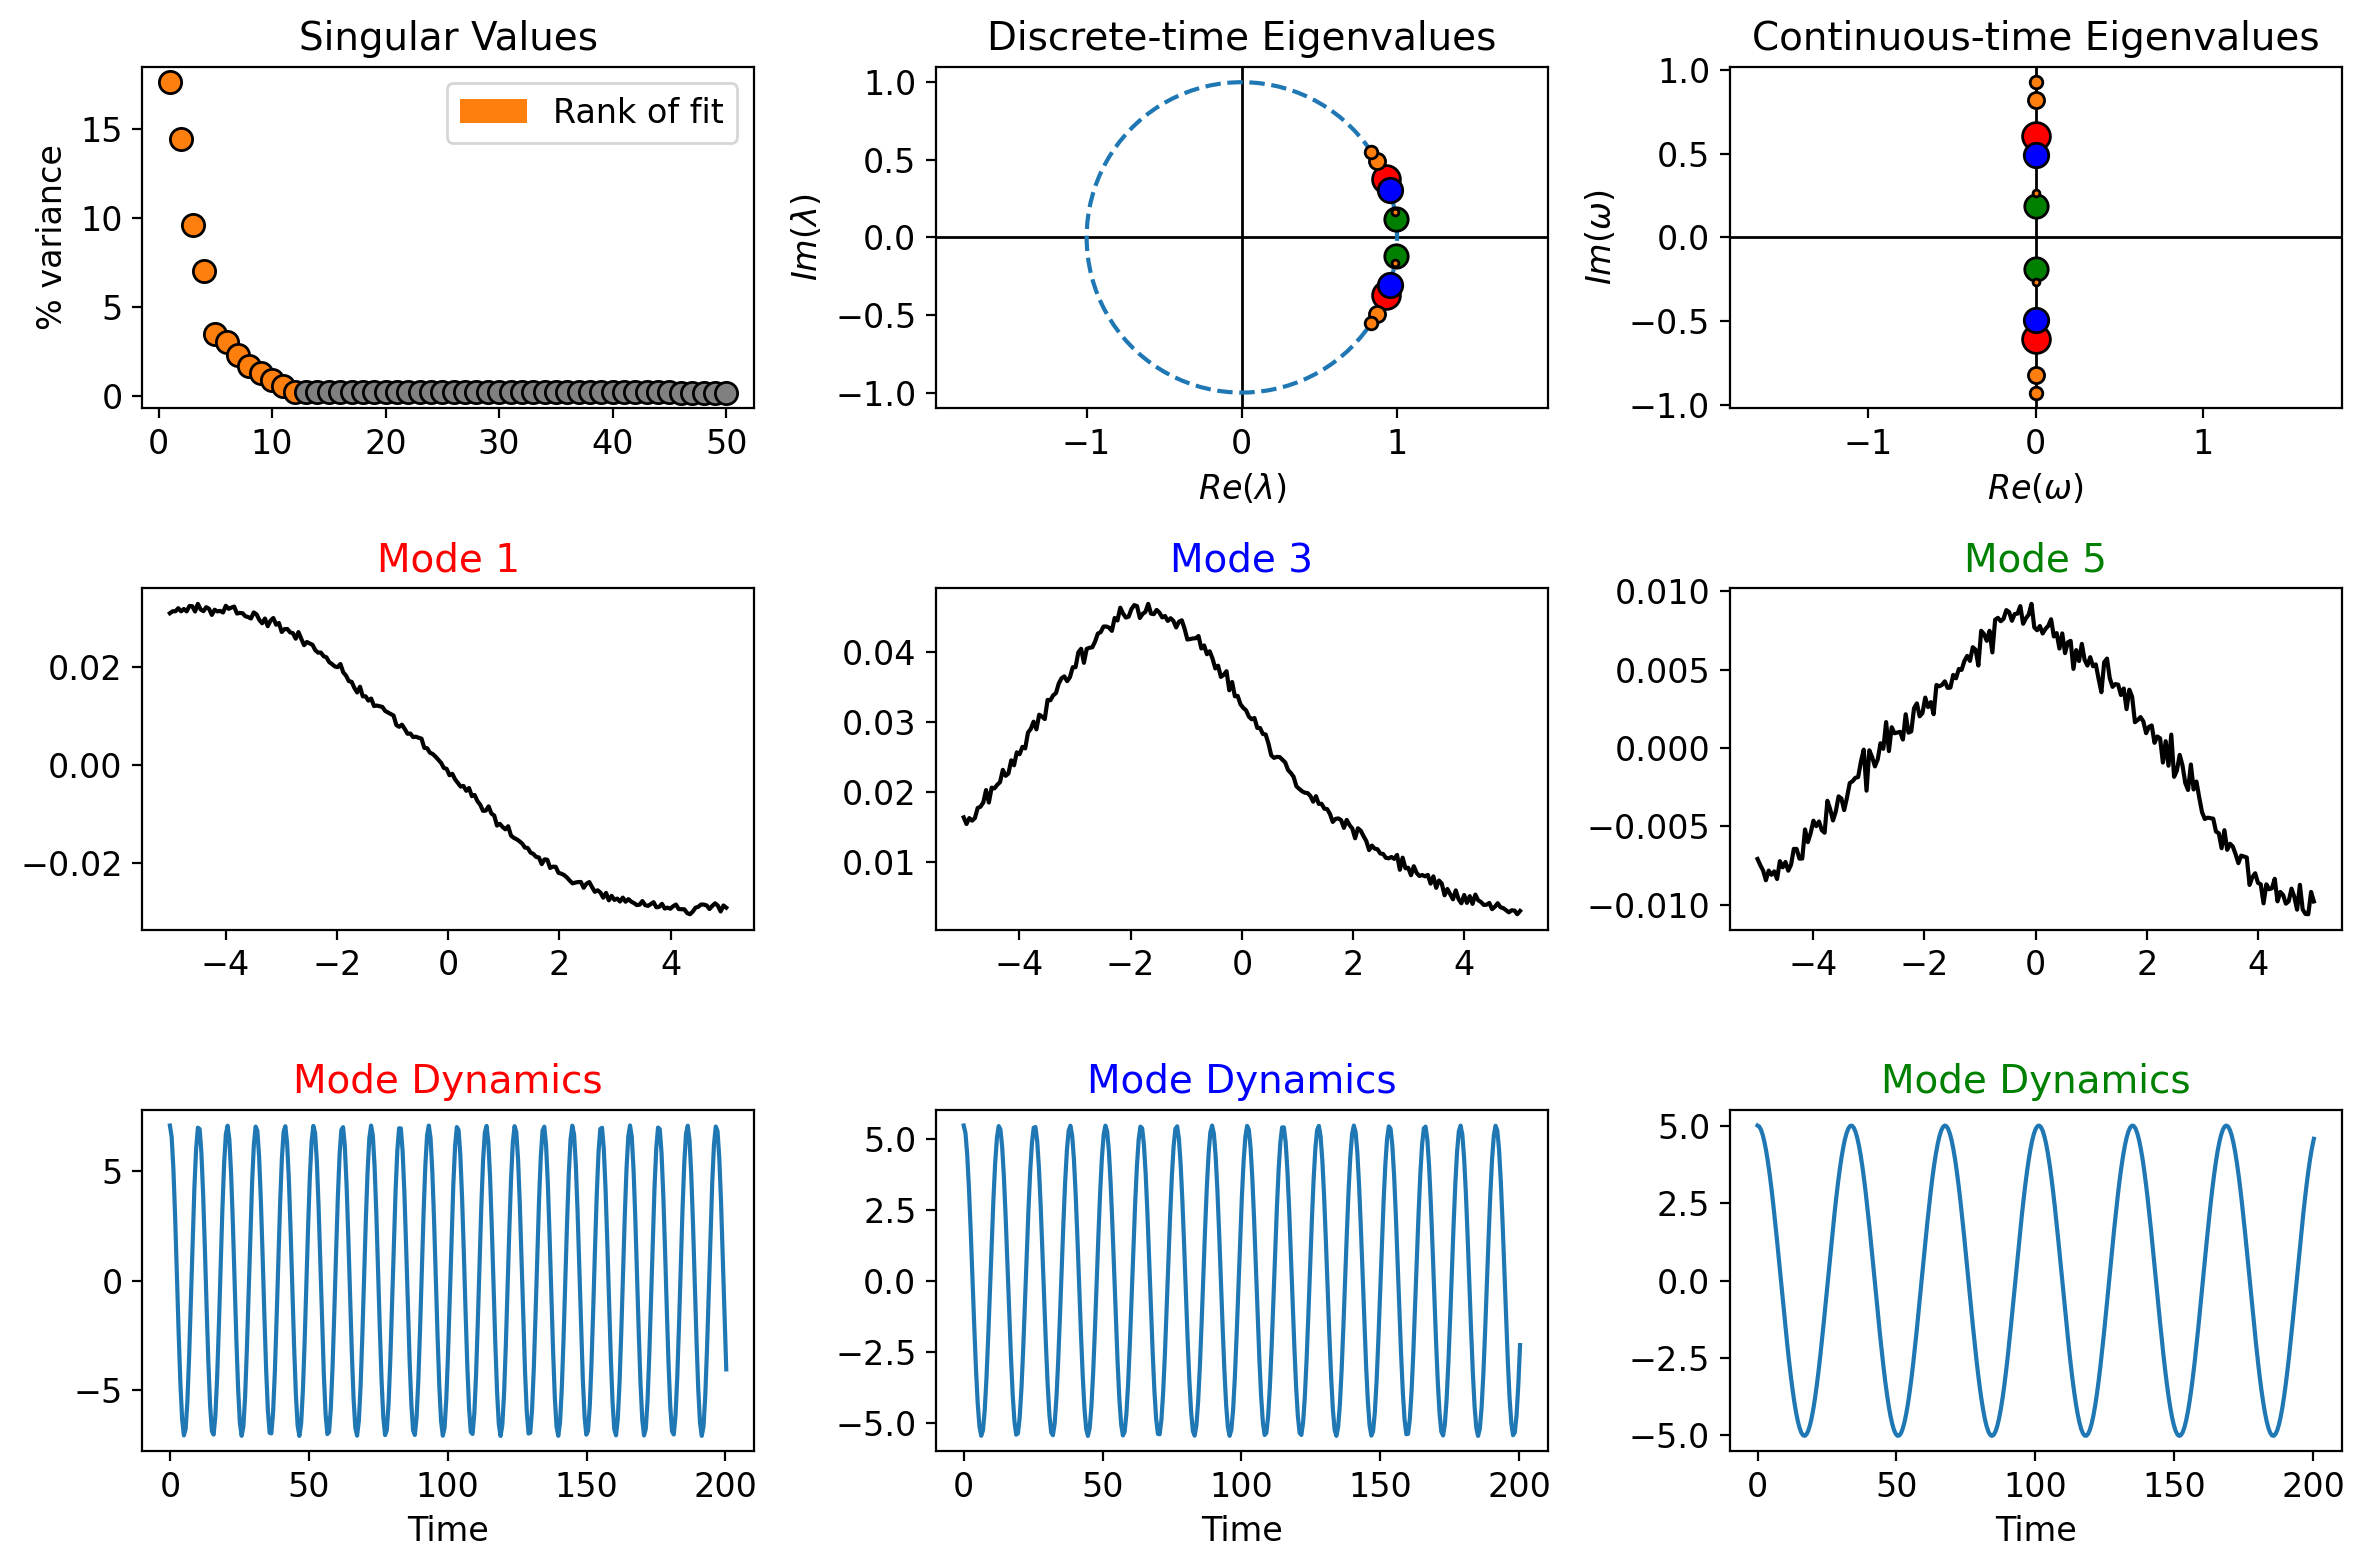

In [16]:
plt.rcParams.update({'font.size': 12})
plot_summary(delay_optdmd, x=signal_generator.x, d=delay, index_modes=[0, 2, 4])

In [17]:
# sort by decreasing amplitude
sorted_index = np.argsort(np.abs(delay_optdmd.amplitudes))[::-1]
delay_optdmd.eigs[sorted_index]

array([ 0.+0.60686849j, -0.-0.60686849j, -0.-0.4919108j ,  0.+0.4919108j ,
       -0.-0.18612742j,  0.+0.18612742j,  0.+0.81760281j, -0.-0.81760281j,
       -0.-0.92531024j,  0.+0.92531024j,  0.+0.26587036j, -0.-0.26587036j])

In [18]:
eigs = delay_optdmd.eigs[sorted_index]
modes = delay_optdmd.modes[:, sorted_index]
dynamics = delay_optdmd.dynamics[sorted_index, :]
amps = delay_optdmd.amplitudes[sorted_index]

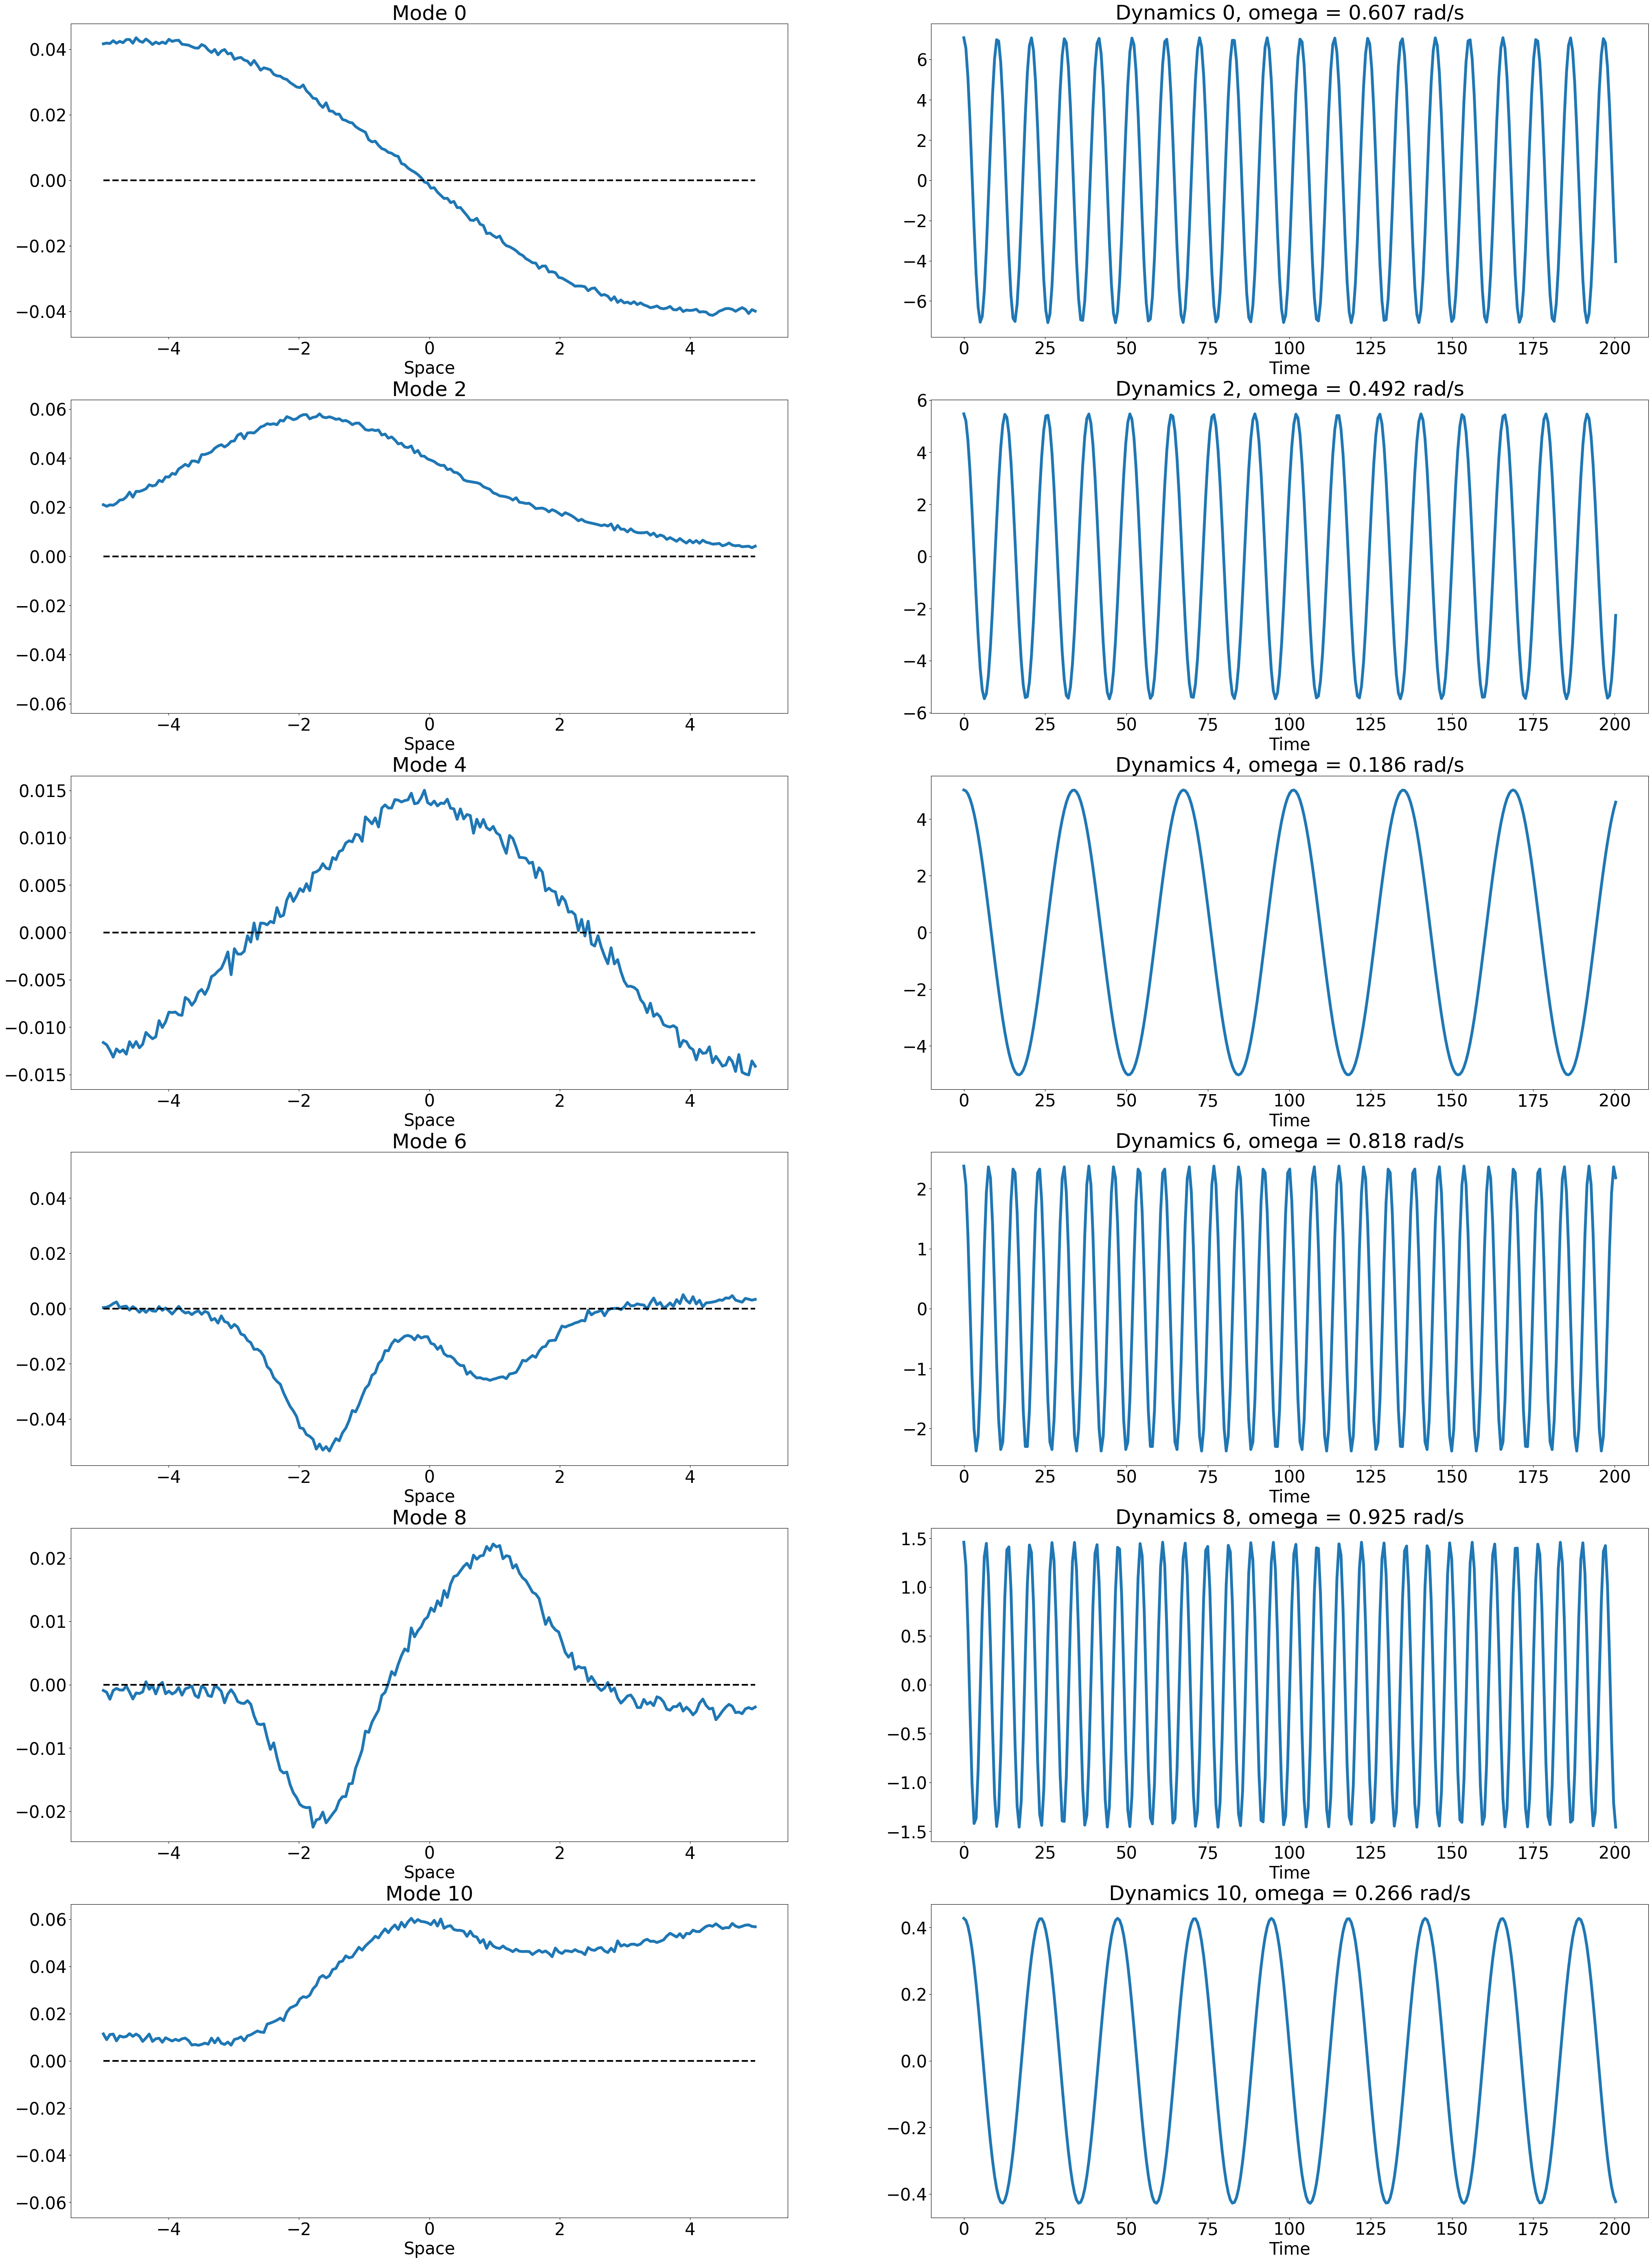

In [19]:
# plot the spatial modes and their dynamics

plt.rcParams.update({'font.size': 30})

which_modes = [0, 2, 4, 6, 8, 10]
fig, axs = plt.subplots(6, 2, figsize=(50, 70))
axs = axs.flatten()

for i, mode in enumerate(which_modes):
    axs[2*i].plot(signal_generator.x, modes[:signal_generator.x.shape[0], mode].real, linewidth=5)
    axs[2*i].set_title(f'Mode {mode}')
    axs[2*i].set_xlabel('Space')
    max_val = np.max(np.abs(modes[:signal_generator.x.shape[0], mode].real))
    axs[2*i].set_ylim([-max_val*1.1, max_val*1.1])
    axs[2*i].hlines(0, signal_generator.x[0], signal_generator.x[-1], color='k', linestyle='--', linewidth=3)

    axs[2*i+1].plot(t_delay, dynamics[mode, :].real, linewidth=5)
    axs[2*i+1].set_title(f'Dynamics {mode}, omega = {np.round(np.abs(eigs[mode].imag), 3)} rad/s')
    axs[2*i+1].set_xlabel('Time')

plt.show()


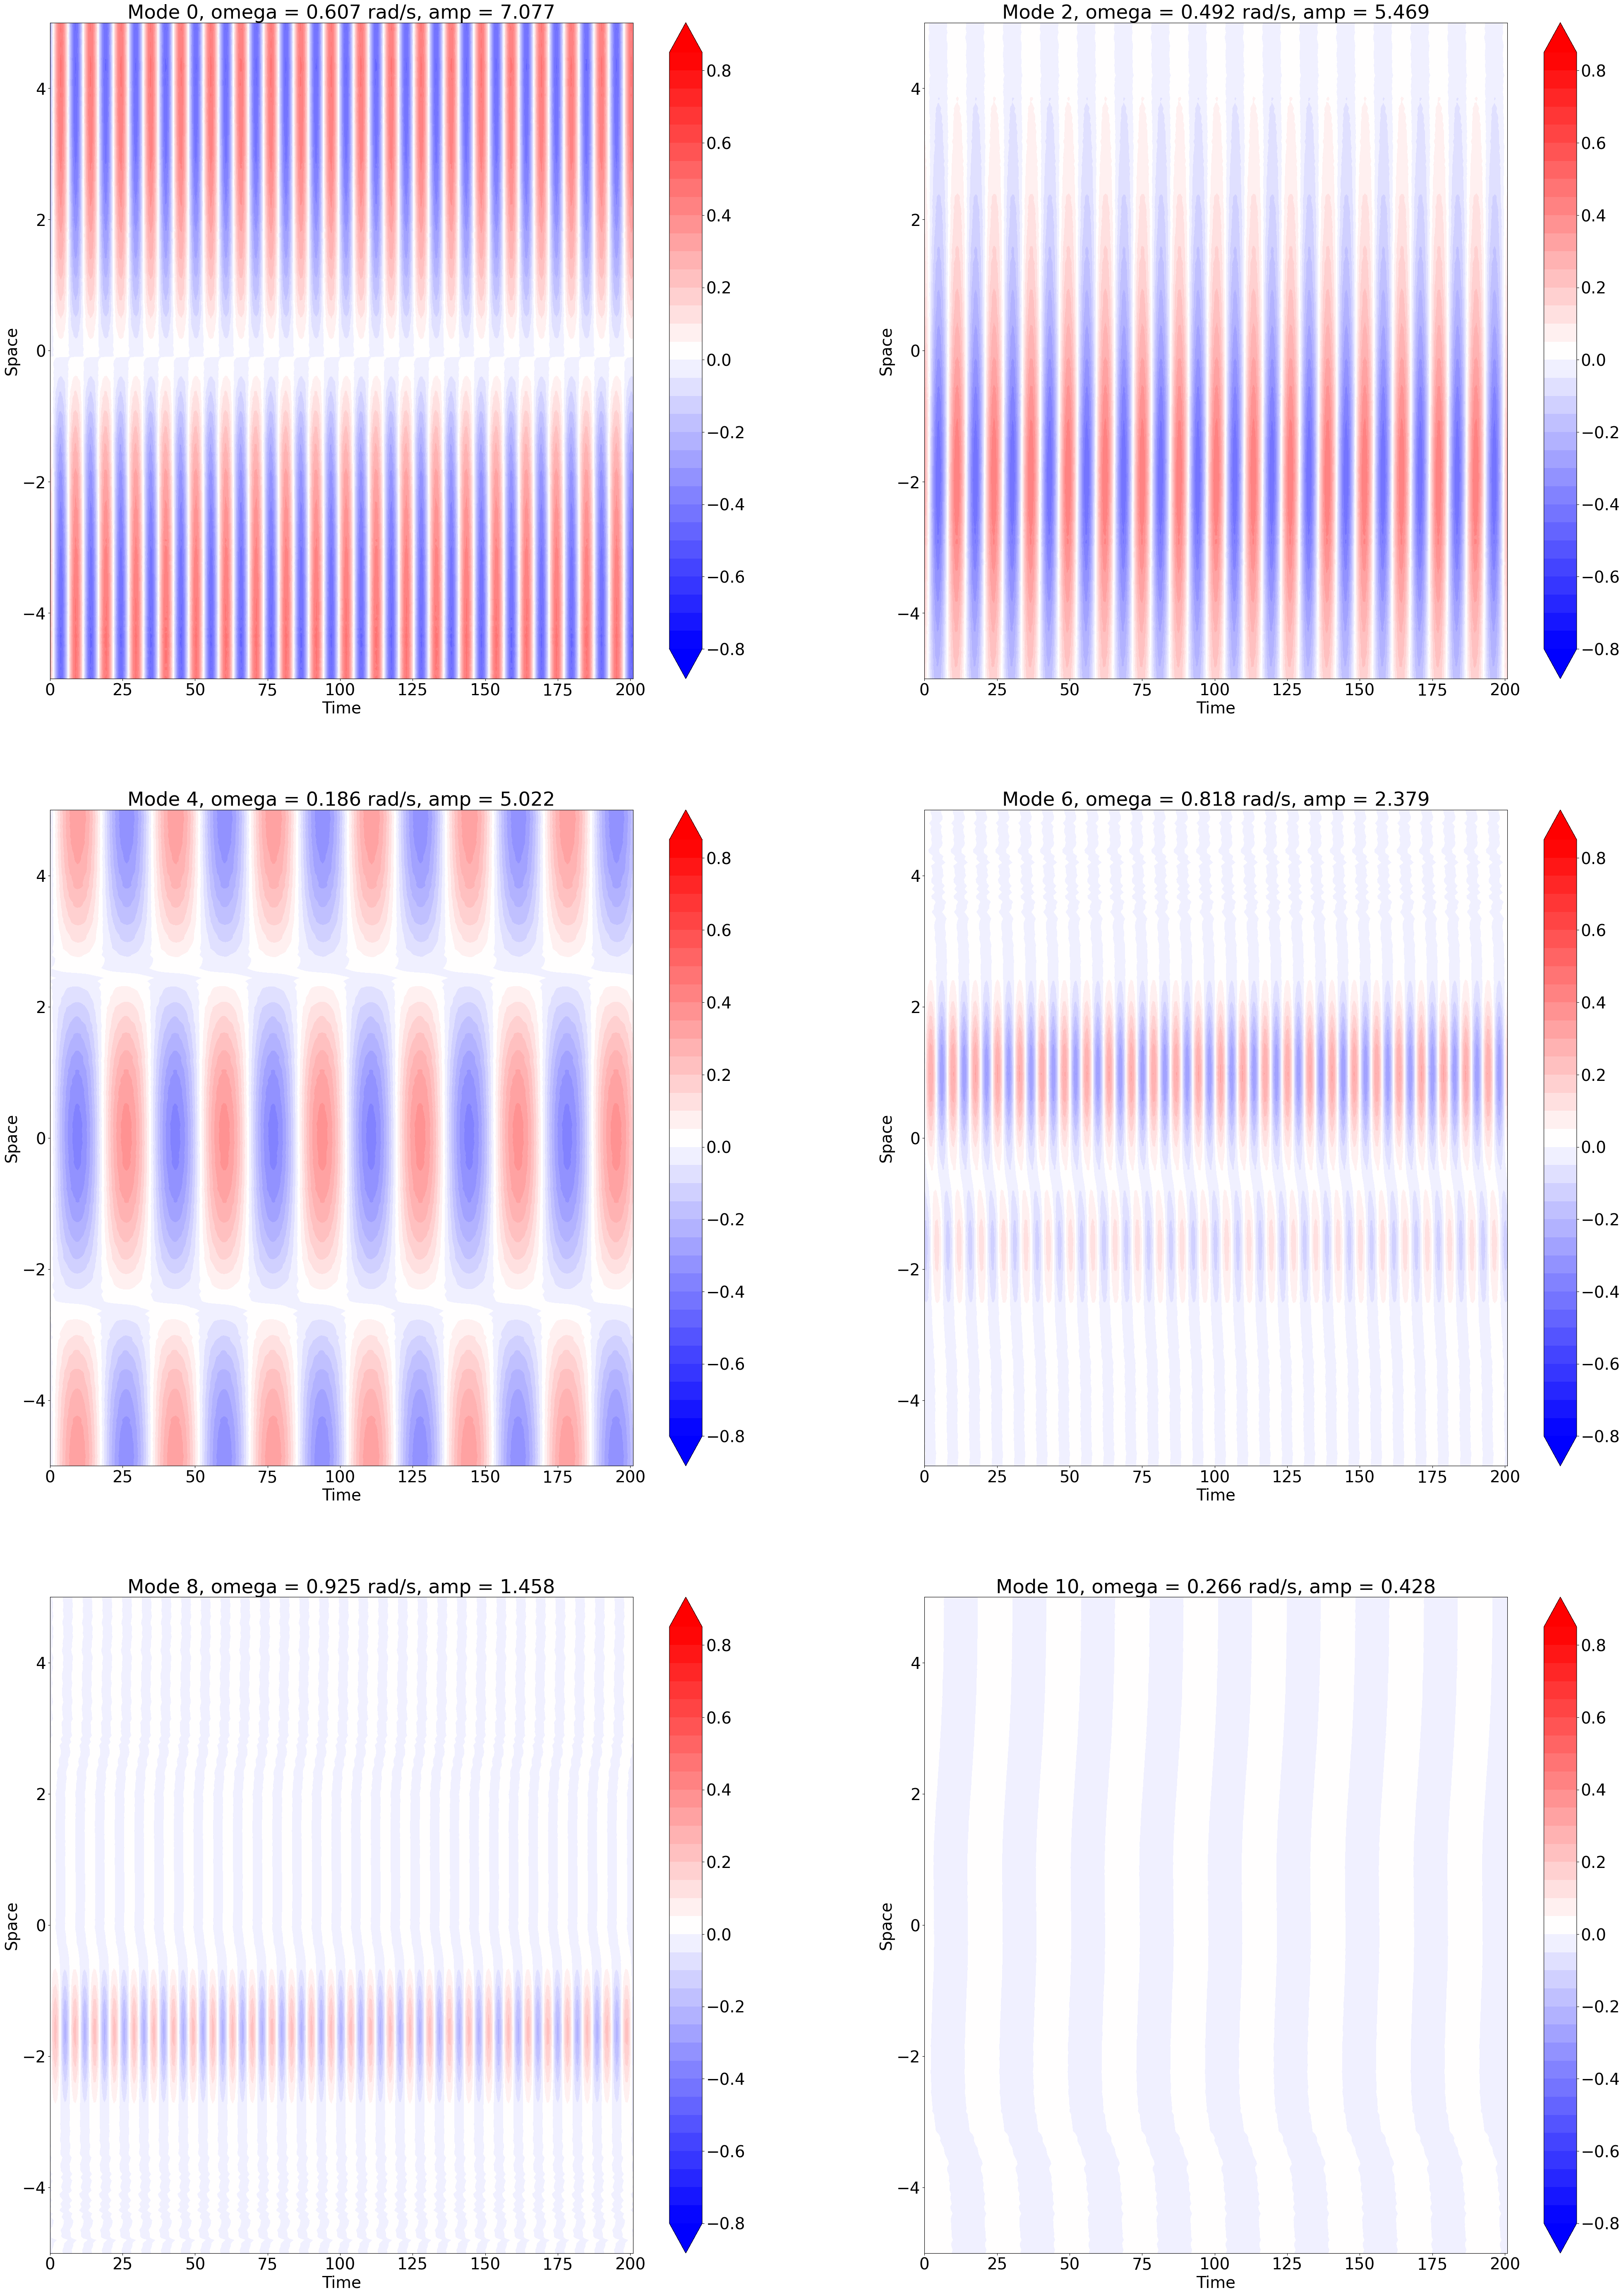

In [20]:
# plot contours of the reconstructed data from each mode
# these should ideally be the same as the individual signals that compose the data

plt.rcParams.update({'font.size': 28})

which_modes = [0, 2, 4, 6, 8, 10]
fig, axs = plt.subplots(3, 2, figsize=(50, 70))
axs = axs.flatten()

vmin = -0.8; vmax = 0.8
levels = np.arange(vmin, vmax+0.1, 0.05)

X, T = np.meshgrid(signal_generator.x, t_train)

for i, mode in enumerate(which_modes):
    reconstruction = np.linalg.multi_dot(
        [modes[:, mode].reshape(-1, 1), np.diag([amps[mode]]), np.exp(np.outer(eigs[mode], t_train))]
        ).real  # this is the reconstruction of the data from each DMD mode
    reconstruction = reconstruction[:signal_generator.x.shape[0], :].T
    reconstruction = scaler.inverse_transform(reconstruction)
    contour = axs[i].contourf(T, X, reconstruction, levels=levels, cmap='bwr', extend='both')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Space')
    axs[i].set_title(f'Mode {mode}, omega = {np.round(np.abs(eigs[mode].imag), 3)} rad/s, amp = {np.round(amps[mode], 3)}')
    plt.colorbar(contour, ax=axs[i], orientation="vertical")



Perform a forecast using the opt DMD model

In [21]:
forecast = delay_optdmd.forecast(t_test)
forecast = forecast[:signal_generator.x.shape[0], :]  # note than need to do this because of the time delay embedding
forecast = forecast.T
forecast = forecast.real
forecast = scaler.inverse_transform(forecast)

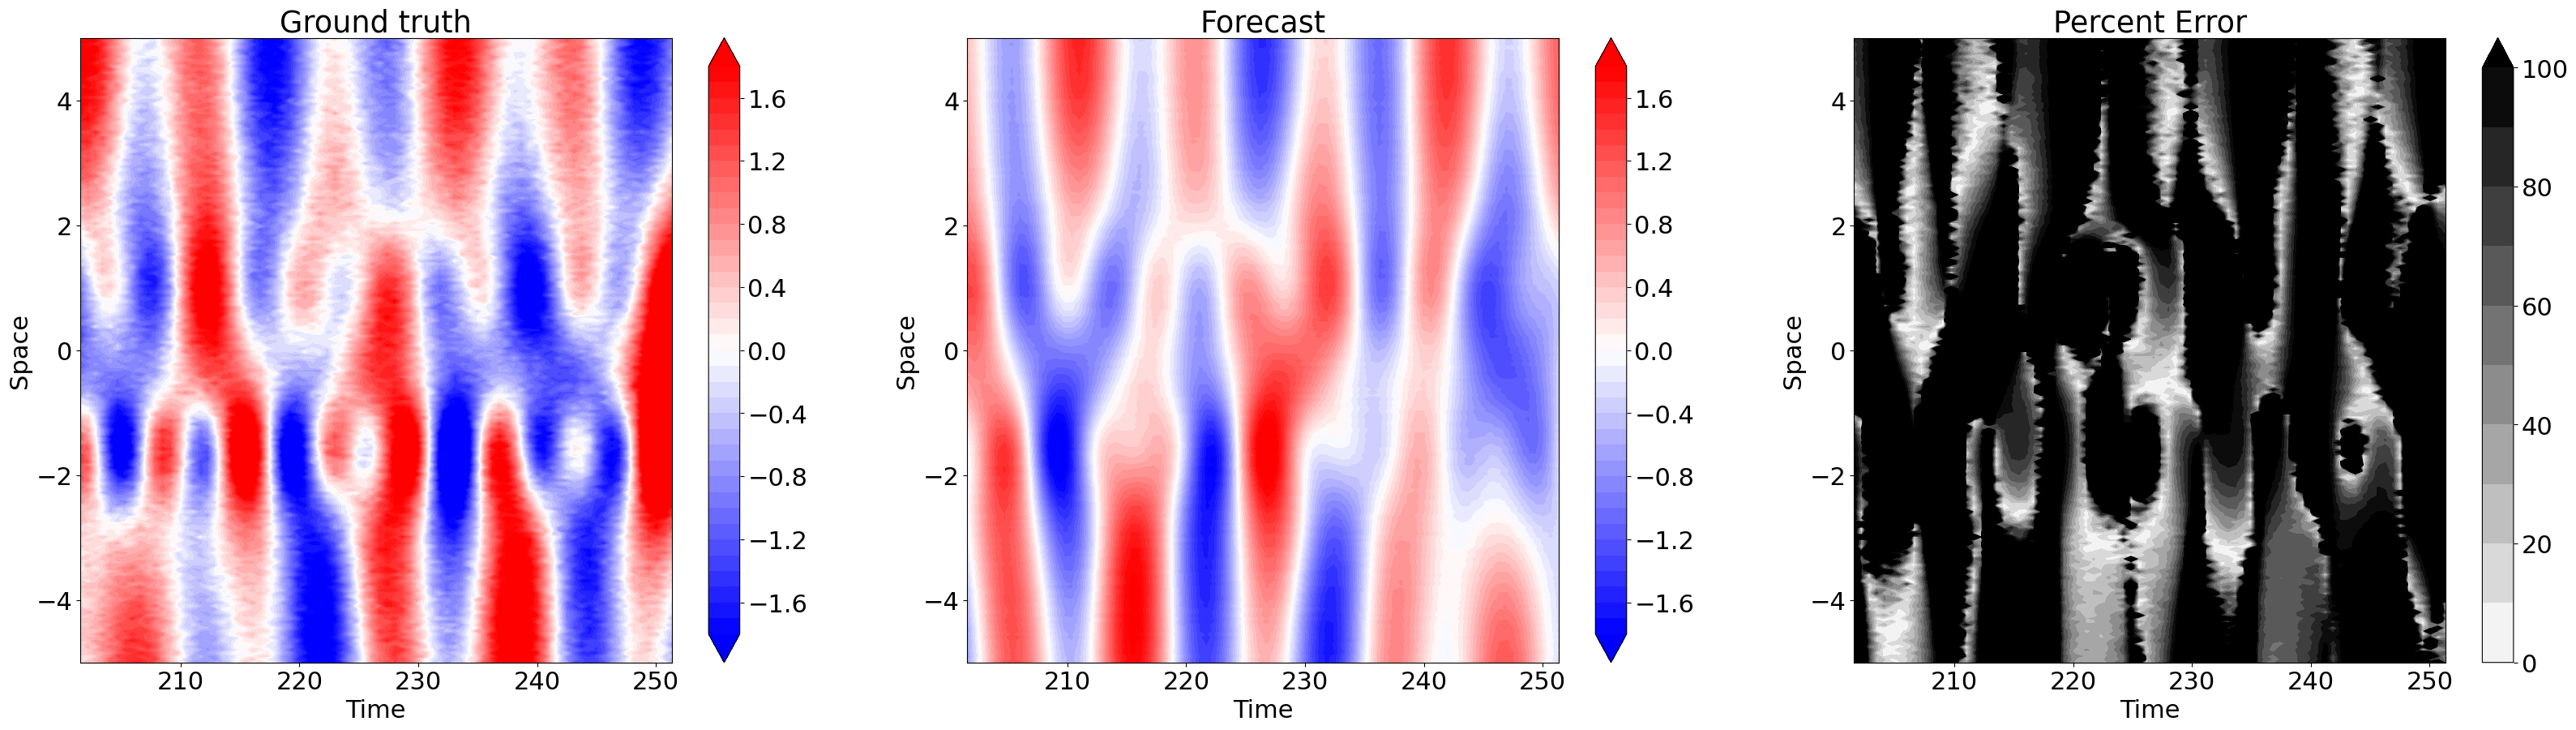

In [22]:
# compare the forecast to the ground truth

plt.rcParams.update({'font.size': 22})

X, T = np.meshgrid(signal_generator.x, t_test) 

fig = plt.figure(figsize=(40, 10))

vmin = -1.8; vmax = 1.8
levels = np.arange(vmin, vmax+0.1, 0.1)

ax = fig.add_subplot(1, 3, 1)
contour = ax.contourf(T, X, f_test, levels=levels, cmap='bwr', extend="both")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title("Ground truth")
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 3, 2)
contour = ax.contourf(T, X, forecast, levels=levels, cmap='bwr', extend="both")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Forecast')
plt.colorbar(contour, ax=ax, orientation="vertical")

# plot the percent error
percent_error = np.abs(f_test - forecast) / np.abs(f_test) * 100
ax = fig.add_subplot(1, 3, 3)
contour = ax.contourf(T, X, percent_error, levels=np.arange(0, 101, 10), cmap='gray_r', extend="max")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Percent Error')
plt.colorbar(contour, ax=ax, orientation="vertical")

plt.show()